##  Load the dataset

The dataset we'll use is a list of opened complain cases with 268,363 records that contains complaint text (**text**), a message identifier (**complaint_id**) and a verified correct complaint department (**product_group**).

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import itertools
import os


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.model_selection import StratifiedKFold

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed()
import nltk
nltk.download('wordnet')
import re
import pandas as pd

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ahmetcakmak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Check the version of TensorFlow
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.13.1


credit_reporting    81231
debt_collection     61459
mortgage            40280
loan                31035
credit_card         29553
bank_service        20071
money_transfers      4734
Name: product_group, dtype: int64


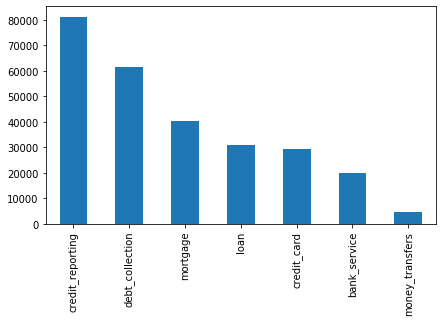

In [7]:
data = pd.read_csv("case_study_data.csv")
print(data['product_group'].value_counts())
plt.figure(figsize=(7,4))
data.product_group.value_counts().plot(kind='bar');



In [8]:
data.head()

,complaint_id,product_group,text
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...
1,2217937,bank_service,I opened a Bank of the the West account. The a...
2,2657456,bank_service,wells fargo in nj opened a business account wi...
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...


##  Data Preprocessing 

For data preprocessing we will execute the following steps

* **Tokenization**: We will split the data into sentences and the sentences into words, then lowercase the entire data_text and remove all punctuations.
* **Remove Stopwords**: All the **stopwords** are removed.
* **Lemmatization**: The words concerning third party will be changed to first person and all past/future tense verbs are converted to present tense  
* **stemming**: All words will be reduced to their root.

In [ ]:
stemmer = SnowballStemmer("english")

def lemm_stemm(x_text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(x_text, pos='v'))

# Tokenize and lemmatize
def preprocess(x_text):
    result=''
    for token in gensim.utils.simple_preprocess(x_text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            # Perform lemm_stemm on the token, then append to the result
            result+=' '+lemm_stemm(token) #.append(lemm_stemm(token))
    return result


In [ ]:
# Preprocess all the complains, saving the list of results as 'processed_data'

processed_data = data['text'].map(preprocess)

In [ ]:
# Save the preprocessed data

cdata.to_csv('processed_data.csv')

In [10]:
# Instead of lemmatize preprocessed  data, we read it and put it back to the data file. 

cdata = pd.read_csv("processed_data.csv",header = None)
cdatas=cdata[:][1].str.replace(r'[^a-zA-Z\s]+|x{2,}', '')

In [11]:
# Some words have lost after lemmatize, therefore we put an arbitrary word instead of them. 

I=cdatas.isnull()
cdatas[I]='money'
data.text=cdatas

**Eventually, the lemmatize 'text' column is inside of the main data**

##  Splitting the Data 

In [ ]:
# Split the data into 10 random parts 

skf = StratifiedKFold(n_splits=10, shuffle = True)

tmp=skf.split(np.zeros(len(data['product_group'])), data['product_group'])
idx_list=[idx for idx in tmp]


In [13]:
# 0.8 train set, 0.10 validation test, 0.1 test set.

testid=idx_list[0][1]
valid=idx_list[1][1]

trainid=idx_list[2][1]
for i in range(3,10):
    trainid=np.hstack((trainid,idx_list[i][1]))


train_posts = data['text'][trainid]
train_tags = data['product_group'][trainid]

val_posts = data['text'][valid]
val_tags = data['product_group'][valid]

test_posts = data['text'][testid]
test_tags = data['product_group'][testid]


In [14]:
# Use tokenizer methods to count the unique words in our vocabulary and assign each of those words to indices.

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

# Only fit on train, calling 'fit_on_texts()' automatically creates a word index lookup of our vocabulary.

tokenize.fit_on_texts(train_posts) 

#mode: one of "binary", "count", "tfidf", "freq"
#With our tokenizer, we can now use the texts_to_matrix method to create the training data 
#that we’ll pass our model.

x_train = tokenize.texts_to_matrix(train_posts,mode="tfidf")   
x_val = tokenize.texts_to_matrix(val_posts,mode="tfidf")
x_test = tokenize.texts_to_matrix(test_posts,mode="tfidf")


In [30]:
# We feed a one-hot vector to our model.

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_val = encoder.transform(val_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

x_train shape: (214685, 1000)
x_val shape: (26838, 1000)
x_test shape: (26840, 1000)
y_train shape: (214685, 7)
y_val shape: (26838, 7)
y_test shape: (26840, 7)


## Running the Model

In [17]:

batch_size = 256
epochs = 20

In [18]:
# After we transform our features and labels in a format Keras can read, 
# We are ready to build our text classification model.
# Build the model
# 1000x512x7 input MLP dimension
# ReLu (y=max(0,x)) is identical for all positive values, and zero for all negative values, 
  # the model can therefore take less time to train or run, converges faster.
# Dropout 75% to prevent overfitting
# we pick activation as softmax since the output of Softmax is a probability distribution.
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
# give the path and check the best performed validation set.

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [20]:
# When we build our model, all we need to do is tell Keras the shape of our input data, output data, 
# and the type of each layer. Keras will take care the rest

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(x_val, y_val)) 

Instructions for updating:
Use tf.cast instead.
Train on 214685 samples, validate on 26838 samples
Epoch 1/20
214685/214685 [==============================] - 9s 43us/step - loss: 0.6770 - accuracy: 0.7822 - val_loss: 0.4943 - val_accuracy: 0.8334

Epoch 00001: val_accuracy improved from -inf to 0.83337, saving model to weights.best.hdf5
Epoch 2/20
214685/214685 [==============================] - 10s 47us/step - loss: 0.5241 - accuracy: 0.8248 - val_loss: 0.4714 - val_accuracy: 0.8384

Epoch 00002: val_accuracy improved from 0.83337 to 0.83840, saving model to weights.best.hdf5
Epoch 3/20
214685/214685 [==============================] - 9s 44us/step - loss: 0.4903 - accuracy: 0.8345 - val_loss: 0.4643 - val_accuracy: 0.8394

Epoch 00003: val_accuracy improved from 0.83840 to 0.83944, saving model to weights.best.hdf5
Epoch 4/20
214685/214685 [==============================] - 9s 40us/step - loss: 0.4712 - accuracy: 0.8400 - val_loss: 0.4578 - val_accuracy: 0.8411

Epoch 00004: val_accu

In [21]:
# To get the best model after training use the path

model.load_weights("weights.best.hdf5")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

26840/26840 [==============================] - 0s 13us/step
Test score: 0.4823048125702649
Test accuracy: 0.8559985160827637


In [23]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

 open bank west account account come promot promot ...
Actual label:bank_service
Predicted label: bank_service

 complaint bank america account start local bank n ...
Actual label:bank_service
Predicted label: bank_service

 bank deposit account balanc prior deposit accord  ...
Actual label:bank_service
Predicted label: bank_service

 account compani account close base malfunct machi ...
Actual label:bank_service
Predicted label: bank_service

 paypal hold account state account link account ow ...
Actual label:bank_service
Predicted label: bank_service

 visit union bank mufg union bank branch branch re ...
Actual label:bank_service
Predicted label: bank_service

 open money market account promot code promot bonu ...
Actual label:bank_service
Predicted label: bank_service

 dear sirmdm submit complaint paypow case number c ...
Actual label:bank_service
Predicted label: mortgage

 hawaiian begin take month total free check knowle ...
Actual label:bank_service
Predicted label: bank_servi

In [24]:
# Final layer outputs. Softmax for multi class categorical problems.

y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [48]:
#   This function prints and plots the confusion matrix. 


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="orange" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


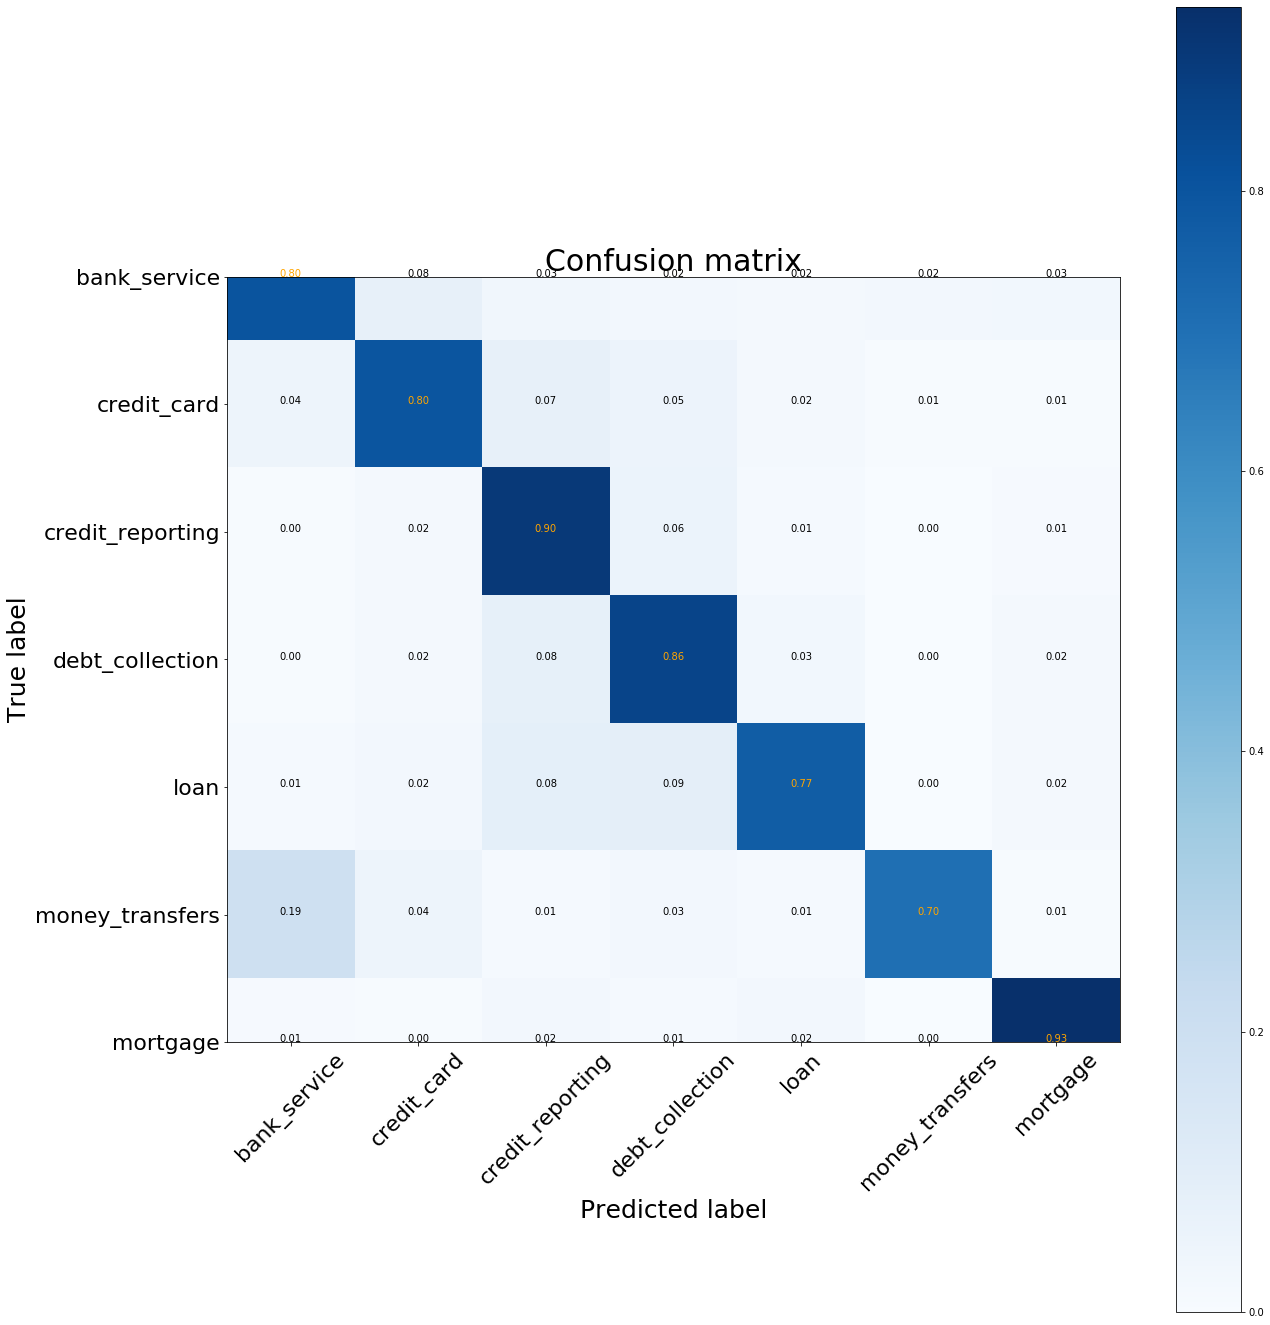

In [51]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(20,24))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## Conclusion

As we can see, the Deep Learning model outperforms then the Naive Bayes and SVC model. Using RNN, BoW, Logistic Regresion might be another way to classify the complains. More importantly, the same model above performed ~83% before we cleaned the dataset. 

There exist, numerous ways to approach to this problem. One is Topic Modeling with Latent Dirichlet Allocation which is very common in semantic text mining based on Expectation MAximization (EM) Algorithm. In this way, we use labeled virtual documents to approach the real documents (complains) in the dataset. Then we make backwords to measure the error metric of our model. 